## imports for Python, Pandas

In [629]:
from collections import Counter, defaultdict

import pandas as pd
import json
from pandas.io.json import json_normalize

****
## JSON exercise

Using data in file 'data/world_bank_projects.json' and the techniques demonstrated above,
1. Find the 10 countries with most projects
2. Find the top 10 major project themes (using column 'mjtheme_namecode')
3. In 2. above you will notice that some entries have only the code and the name is missing. Create a dataframe with the missing names filled in.

In [634]:
# load as Pandas dataframe
json_df = pd.read_json('data/world_bank_projects.json')
json_df.head()

,_id,approvalfy,board_approval_month,boardapprovaldate,borrower,closingdate,country_namecode,countrycode,countryname,countryshortname,docty,envassesmentcategorycode,grantamt,ibrdcommamt,id,idacommamt,impagency,lendinginstr,lendinginstrtype,lendprojectcost,majorsector_percent,mjsector_namecode,mjtheme,mjtheme_namecode,mjthemecode,prodline,prodlinetext,productlinetype,project_abstract,project_name,projectdocs,projectfinancialtype,projectstatusdisplay,regionname,sector,sector1,sector2,sector3,sector4,sector_namecode,sectorcode,source,status,supplementprojectflg,theme1,theme_namecode,themecode,totalamt,totalcommamt,url
0,{'$oid': '52b213b38594d8a2be17c780'},1999,November,2013-11-12T00:00:00Z,FEDERAL DEMOCRATIC REPUBLIC OF ETHIOPIA,2018-07-07T00:00:00Z,Federal Democratic Republic of Ethiopia!$!ET,ET,Federal Democratic Republic of Ethiopia,Ethiopia,"Project Information Document,Indigenous People...",C,0,0,P129828,130000000,MINISTRY OF EDUCATION,Investment Project Financing,IN,550000000,"[{'Percent': 46, 'Name': 'Education'}, {'Perce...","[{'code': 'EX', 'name': 'Education'}, {'code':...",[Human development],"[{'code': '8', 'name': 'Human development'}, {...","8,11",PE,IBRD/IDA,L,{'cdata': 'The development objective of the Se...,Ethiopia General Education Quality Improvement...,"[{'DocDate': '28-AUG-2013', 'EntityID': '09022...",IDA,Active,Africa,"[{'Name': 'Primary education'}, {'Name': 'Seco...","{'Percent': 46, 'Name': 'Primary education'}","{'Percent': 26, 'Name': 'Secondary education'}","{'Percent': 16, 'Name': 'Public administration...","{'Percent': 12, 'Name': 'Tertiary education'}","[{'code': 'EP', 'name': 'Primary education'}, ...","ET,BS,ES,EP",IBRD,Active,N,"{'Percent': 100, 'Name': 'Education for all'}","[{'code': '65', 'name': 'Education for all'}]",65,130000000,130000000,http://www.worldbank.org/projects/P129828/ethi...
1,{'$oid': '52b213b38594d8a2be17c781'},2015,November,2013-11-04T00:00:00Z,GOVERNMENT OF TUNISIA,NaN,Republic of Tunisia!$!TN,TN,Republic of Tunisia,Tunisia,"Project Information Document,Integrated Safegu...",C,4700000,0,P144674,0,MINISTRY OF FINANCE,Specific Investment Loan,IN,5700000,"[{'Percent': 70, 'Name': 'Public Administratio...","[{'code': 'BX', 'name': 'Public Administration...","[Economic management, Social protection and ri...","[{'code': '1', 'name': 'Economic management'},...","1,6",RE,Recipient Executed Activities,L,NaN,TN: DTF Social Protection Reforms Support,"[{'DocDate': '29-MAR-2013', 'EntityID': '00033...",OTHER,Active,Middle East and North Africa,[{'Name': 'Public administration- Other social...,"{'Percent': 70, 'Name': 'Public administration...","{'Percent': 30, 'Name': 'General public admini...",NaN,NaN,"[{'code': 'BS', 'name': 'Public administration...","BZ,BS",IBRD,Active,N,"{'Percent': 30, 'Name': 'Other economic manage...","[{'code': '24', 'name': 'Other economic manage...","54,24",0,4700000,http://www.worldbank.org/projects/P144674?lang=en
2,{'$oid': '52b213b38594d8a2be17c782'},2014,November,2013-11-01T00:00:00Z,MINISTRY OF FINANCE AND ECONOMIC DEVEL,NaN,Tuvalu!$!TV,TV,Tuvalu,Tuvalu,"Resettlement Plan,Environmental Assessment,Int...",B,0,0,P145310,6060000,MINISTRY OF TRANSPORT AND COMMUNICATIONS,Investment Project Financing,IN,6060000,"[{'Percent': 100, 'Name': 'Transportation'}]","[{'code': 'TX', 'name': 'Transportation'}]","[Trade and integration, Public sector governan...","[{'code': '5', 'name': 'Trade and integration'...","5,2,11,6",PE,IBRD/IDA,L,NaN,Tuvalu Aviation Investment Project - Additiona...,"[{'DocDate': '21-OCT-2013', 'EntityID': '00033...",IDA,Active,East Asia and Pacific,[{'Name': 'Rural and Inter-Urban Roads and Hig...,"{'Percent': 100, 'Name': 'Rural and Inter-Urba...",NaN,NaN,NaN,"[{'code': 'TI', 'name': 'Rural and Inter-Urban...",TI,IBRD,Active,Y,"{'Percent': 46, 'Name': 'Regional integration'}","[{'code': '47', 'name': 'Regional integration'...","52,81,25,47",6060000,6060000,http://www.worldbank.org/projects/P145310?lang=en
3,{'$oid': '52b213b38594d8a2be17

In [635]:
%matplotlib inline

## 1. Find the 10 countries with most projects:

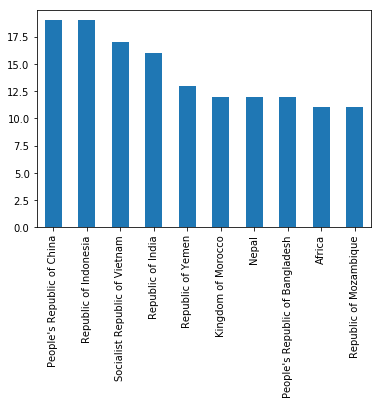

In [638]:
df.countryname.value_counts().head(10).plot(kind='bar')

(Africa is problematically listed as a country, but there's not an obvious way to recover country by country information.)

## 2. Find the top 10 major project themes (using column 'mjtheme_namecode'):

It looks like each row contains several theme codes, as the value of the column is a list of dictionaries:

In [639]:
df = json_df
df['mjtheme_namecode'].get(2)

[{'code': '5', 'name': 'Trade and integration'},
 {'code': '2', 'name': 'Public sector governance'},
 {'code': '11', 'name': 'Environment and natural resources management'},
 {'code': '6', 'name': 'Social protection and risk management'}]

#### Solution 1
To count up the theme instances, we can define a function to iterate through each dictionary's theme names and append them to a global list.

In [653]:
theme_name_list = []
def count_list_of_dicts(list_of_dicts):
    """counts up instances of theme codes and stores the count in a global dictionary"""
    for d in list_of_dicts:
        theme_name_list.append(d['name'])

Then we can apply the function to the dataframe column using `apply`, after which we can use a `Counter` to count up the ten most common themes in our theme_name_list.

In [641]:

df['mjtheme_namecode'].apply(count_list_of_dicts)
c = Counter(theme_name_list).most_common(10)
c

[('Environment and natural resources management', 223),
 ('Rural development', 202),
 ('Human development', 197),
 ('Public sector governance', 184),
 ('Social protection and risk management', 158),
 ('Financial and private sector development', 130),
 ('', 122),
 ('Social dev/gender/inclusion', 119),
 ('Trade and integration', 72),
 ('Urban development', 47)]

#### Solution 2
It might be more meaningful, from the perspective of some hypothetical decision, to ask which combinations of themes occur most frequently, as well as single-themed projects, rather than which theme tags occur most often in the dataset:

In [642]:
df = json_df
theme_combination_counts = df['mjtheme_namecode'].apply(lambda dict_list: Counter([d['name'] for d in dict_list]).keys()).value_counts()
theme_combination_counts.head(10)

(Human development, )                                                22
(Environment and natural resources management, )                     21
(Human development)                                                  20
(Environment and natural resources management)                       16
(Public sector governance, )                                         16
(Environment and natural resources management, Rural development)    13
(Rural development, )                                                13
(Rural development, Social dev/gender/inclusion)                     11
(Financial and private sector development, )                         10
(Public sector governance)                                            9
Name: mjtheme_namecode, dtype: int64

Finally, we can use the resulting counter to plot a bar graph of the total tag counts (distorted by missing values and to be subsequently corrected),

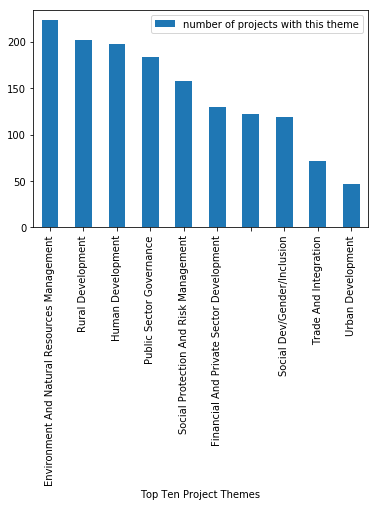

In [643]:
df = pd.DataFrame(c, columns=['Top Ten Project Themes', 'number of projects with this theme'])
df['Top Ten Project Themes'] = df['Top Ten Project Themes'].str.title()
df = df.set_index('Top Ten Project Themes')
df.plot(kind='bar')

...or the total theme counts, including theme combinations ((distorted by missing values and to be subsequently corrected)):

,mjtheme_namecode
"(Human development, )",22
"(Environment and natural resources management, )",21
(Human development),20
(Environment and natural resources management),16
"(Public sector governance, )",16
"(Environment and natural resources management, Rural development)",13
"(Rural development, )",13
"(Rural development, Social dev/gender/inclusion)",11
"(Financial and private sector development, )",10
(Public sector governance),9


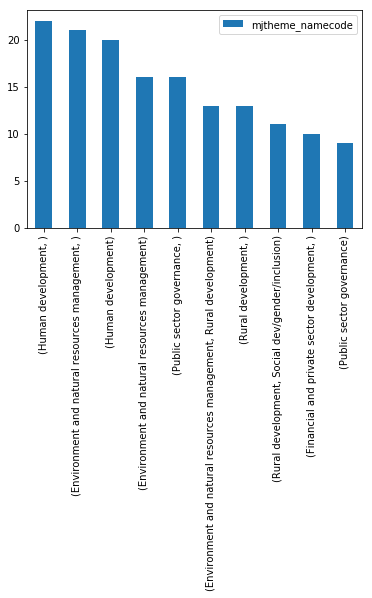

In [644]:
combos_df = pd.DataFrame(theme_combination_counts).head(10)
combos_df.plot(kind='bar')
combos_df.head(10)
# theme_combination_counts.head(10).plot(kind='bar')

## 3. In 2. above you will notice that some entries have only the code and the name is missing. Create a dataframe with the missing names filled in. ##

The plot above reveals that a substantial number of entries have at least one empty name field:

In [663]:
df = json_df
# returns True if a name value is blank
df['mjtheme_namecode'].apply(lambda dict_list: '' in Counter([d['name'] for d in dict_list])).value_counts().head(10)

False    500
Name: mjtheme_namecode, dtype: int64

To fix the missing data, we need to be able to look up project themes by their codes. We can build a master dictionary of codes and project themes from the column in question:

In [664]:
from collections import defaultdict
master_theme_dict = {}

def build_theme_dict(list_of_dicts):
    for d in list_of_dicts:
        if d['code'] not in master_theme_dict and d['name'] != '':
            master_theme_dict[d['code']] = d['name']
                
df['mjtheme_namecode'].apply(build_theme_dict)

master_theme_dict

{'8': 'Human development',
 '11': 'Environment and natural resources management',
 '1': 'Economic management',
 '6': 'Social protection and risk management',
 '5': 'Trade and integration',
 '2': 'Public sector governance',
 '7': 'Social dev/gender/inclusion',
 '4': 'Financial and private sector development',
 '10': 'Rural development',
 '9': 'Urban development',
 '3': 'Rule of law'}

Then we use this dictionary to repair each column value. A first helper function repairs a missing value by looking it up in the master project theme dictionary:

In [665]:
def repair_missing_names_in_dict(the_dict):
    if the_dict['name'] == '':
        the_dict['name'] = master_theme_dict[the_dict['code']]
    return the_dict

And a second helper function applies the first to repair the dictionaries in each value of the column:

In [666]:
def fix_list_of_dicts(dict_list):
    for d in dict_list:
        repair_missing_names_in_dict(d)
    return dict_list

We then apply the helper function to the column for an in-place transformation using `map`.

In [667]:
df['mjtheme_namecode'] = df['mjtheme_namecode'].map(fix_list_of_dicts)
df.head()

,_id,approvalfy,board_approval_month,boardapprovaldate,borrower,closingdate,country_namecode,countrycode,countryname,countryshortname,docty,envassesmentcategorycode,grantamt,ibrdcommamt,id,idacommamt,impagency,lendinginstr,lendinginstrtype,lendprojectcost,majorsector_percent,mjsector_namecode,mjtheme,mjtheme_namecode,mjthemecode,prodline,prodlinetext,productlinetype,project_abstract,project_name,projectdocs,projectfinancialtype,projectstatusdisplay,regionname,sector,sector1,sector2,sector3,sector4,sector_namecode,sectorcode,source,status,supplementprojectflg,theme1,theme_namecode,themecode,totalamt,totalcommamt,url
0,{'$oid': '52b213b38594d8a2be17c780'},1999,November,2013-11-12T00:00:00Z,FEDERAL DEMOCRATIC REPUBLIC OF ETHIOPIA,2018-07-07T00:00:00Z,Federal Democratic Republic of Ethiopia!$!ET,ET,Federal Democratic Republic of Ethiopia,Ethiopia,"Project Information Document,Indigenous People...",C,0,0,P129828,130000000,MINISTRY OF EDUCATION,Investment Project Financing,IN,550000000,"[{'Percent': 46, 'Name': 'Education'}, {'Perce...","[{'code': 'EX', 'name': 'Education'}, {'code':...",[Human development],"[{'code': '8', 'name': 'Human development'}, {...","8,11",PE,IBRD/IDA,L,{'cdata': 'The development objective of the Se...,Ethiopia General Education Quality Improvement...,"[{'DocDate': '28-AUG-2013', 'EntityID': '09022...",IDA,Active,Africa,"[{'Name': 'Primary education'}, {'Name': 'Seco...","{'Percent': 46, 'Name': 'Primary education'}","{'Percent': 26, 'Name': 'Secondary education'}","{'Percent': 16, 'Name': 'Public administration...","{'Percent': 12, 'Name': 'Tertiary education'}","[{'code': 'EP', 'name': 'Primary education'}, ...","ET,BS,ES,EP",IBRD,Active,N,"{'Percent': 100, 'Name': 'Education for all'}","[{'code': '65', 'name': 'Education for all'}]",65,130000000,130000000,http://www.worldbank.org/projects/P129828/ethi...
1,{'$oid': '52b213b38594d8a2be17c781'},2015,November,2013-11-04T00:00:00Z,GOVERNMENT OF TUNISIA,NaN,Republic of Tunisia!$!TN,TN,Republic of Tunisia,Tunisia,"Project Information Document,Integrated Safegu...",C,4700000,0,P144674,0,MINISTRY OF FINANCE,Specific Investment Loan,IN,5700000,"[{'Percent': 70, 'Name': 'Public Administratio...","[{'code': 'BX', 'name': 'Public Administration...","[Economic management, Social protection and ri...","[{'code': '1', 'name': 'Economic management'},...","1,6",RE,Recipient Executed Activities,L,NaN,TN: DTF Social Protection Reforms Support,"[{'DocDate': '29-MAR-2013', 'EntityID': '00033...",OTHER,Active,Middle East and North Africa,[{'Name': 'Public administration- Other social...,"{'Percent': 70, 'Name': 'Public administration...","{'Percent': 30, 'Name': 'General public admini...",NaN,NaN,"[{'code': 'BS', 'name': 'Public administration...","BZ,BS",IBRD,Active,N,"{'Percent': 30, 'Name': 'Other economic manage...","[{'code': '24', 'name': 'Other economic manage...","54,24",0,4700000,http://www.worldbank.org/projects/P144674?lang=en
2,{'$oid': '52b213b38594d8a2be17c782'},2014,November,2013-11-01T00:00:00Z,MINISTRY OF FINANCE AND ECONOMIC DEVEL,NaN,Tuvalu!$!TV,TV,Tuvalu,Tuvalu,"Resettlement Plan,Environmental Assessment,Int...",B,0,0,P145310,6060000,MINISTRY OF TRANSPORT AND COMMUNICATIONS,Investment Project Financing,IN,6060000,"[{'Percent': 100, 'Name': 'Transportation'}]","[{'code': 'TX', 'name': 'Transportation'}]","[Trade and integration, Public sector governan...","[{'code': '5', 'name': 'Trade and integration'...","5,2,11,6",PE,IBRD/IDA,L,NaN,Tuvalu Aviation Investment Project - Additiona...,"[{'DocDate': '21-OCT-2013', 'EntityID': '00033...",IDA,Active,East Asia and Pacific,[{'Name': 'Rural and Inter-Urban Roads and Hig...,"{'Percent': 100, 'Name': 'Rural and Inter-Urba...",NaN,NaN,NaN,"[{'code': 'TI', 'name': 'Rural and Inter-Urban...",TI,IBRD,Active,Y,"{'Percent': 46, 'Name': 'Regional integration'}","[{'code': '47', 'name': 'Regional integration'...","52,81,25,47",6060000,6060000,http://www.worldbank.org/projects/P145310?lang=en
3,{'$oid': '52b213b38594d8a2be17

And now none of the values' dictionaries contain empty name fields:

In [668]:
# returns True if a name value is blank but now returns False for all values
df['mjtheme_namecode'].apply(lambda dict_list: '' in Counter([d['name'] for d in dict_list])).value_counts().head(10)

False    500
Name: mjtheme_namecode, dtype: int64

Now that the data have been repaired, the process from 2. produces plots without any unthemed projects, first of the occurence of single theme tages:

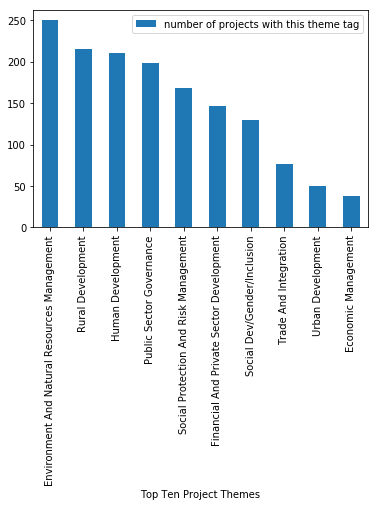

In [669]:
theme_name_list = []
df['mjtheme_namecode'].apply(count_list_of_dicts)
c = Counter(theme_name_list).most_common(10)
df = pd.DataFrame(c, columns=['Top Ten Project Themes', 'number of projects with this theme tag'])
df['Top Ten Project Themes'] = df['Top Ten Project Themes'].str.title()
df = df.set_index('Top Ten Project Themes')
df.plot(kind='bar')

And lastly, as in the second solution to 2., the number of projects with each theme combination:

In [693]:
df = json_df
theme_combination_counts = df['mjtheme_namecode'].apply(lambda dict_list: Counter([d['name'] for d in dict_list]).keys()).value_counts()
df = theme_combination_counts.index.str.replace(r"\(.*\)","")
# combos_df = pd.DataFrame(theme_combination_counts).head(10)
# combos_df.plot(kind='bar')
# combos_df.head(10)
# theme_combination_counts.head(10).plot(kind='bar')